In [191]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.covariance import MinCovDet
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from matplotlib.colors import TwoSlopeNorm, LogNorm
from sklearn.base import BaseEstimator, TransformerMixin

In [192]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(X)
    return nullOrd


def computeCorrelation(df, p=0.05):
    """ Compute pairwise correlation, p-value and pair counts """
    correlations = []
    for method in ['kendall', kendalltaur_pval, countPair]:
        values = df.corr(method=method).stack()
        correlations.append(values)
    correlations = (
        pd.concat(correlations, axis=1)
        .reset_index()
        .rename(columns={'level_0': 'feature1',
                         'level_1': 'feature2',
                         0: 'R', 1: 'p', 2: 'n'}))
    correlations['significant'] = correlations['p'] < p
    correlations = correlations[correlations['feature1'] != correlations['feature2']]
    return correlations


def kendalltaur_pval(x,y):
    try:
        return kendalltau(x,y)[1]
    except ValueError:
        return np.nan


def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)


def plotTargetCorrelation(correlations, feature, out=None):
    """ Plot correlations relative to feature """
    targetCorr = (
        correlations.loc[correlations['feature1'] == feature]
        .set_index('feature2'))
    targetCorr = targetCorr.sort_values(by=['p'], ascending=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    targetCorr = targetCorr.loc[targetCorr.index != targetCorr['feature1']]
    sns.heatmap(pd.DataFrame(targetCorr['R']), yticklabels=1, cmap='bwr',
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(targetCorr['p']), yticklabels=1,
                cmap='viridis_r', norm=LogNorm(vmax=1), ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, (ax1, ax2)


def plotPairwiseCorrelation(correlations, out=None):
    """ Plot pairwise correlation matrix with
        output from computeCorrelation() """
    wideCorr = correlations.pivot(
        columns='feature1', index='feature2', values='R')
    fig, ax = plt.subplots()
    sns.heatmap(wideCorr, yticklabels=1, cmap='bwr', square=True,
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('lightgrey')
    ax.tick_params(left=True)
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, ax


In [193]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)
warnings.filterwarnings('ignore')

In [194]:
train = 'train.csv'
test = 'test.csv'
index = 'PassengerId'
target = 'Survived'

In [636]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     str,
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
X = pd.read_csv(train, index_col=index, dtype=dtypes)

In [196]:
# Perform ordinal encoding here if necessary, 

In [197]:
allCorrelations = computeCorrelation(X)

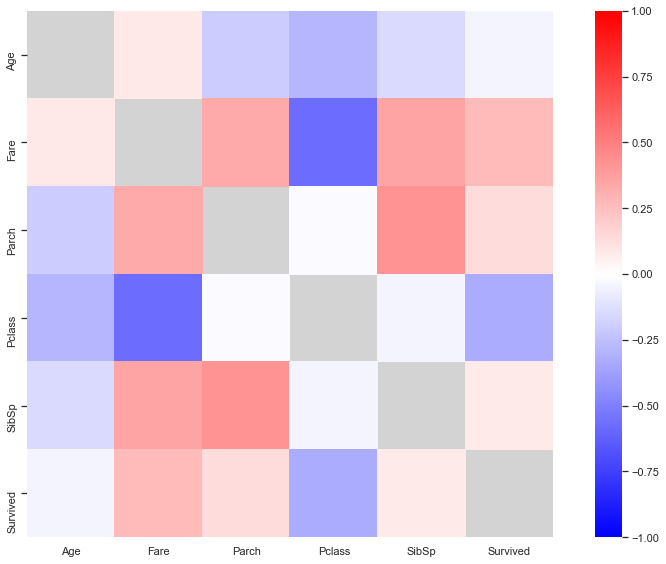

In [198]:
fig, ax = plotPairwiseCorrelation(allCorrelations)

In [199]:
missingVals = showMissing(X)
print(missingVals)

          TotalNA    PropNA
Cabin         687  0.771044
Age           177  0.198653
Embarked        2  0.002245


(<Figure size 864x576 with 4 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

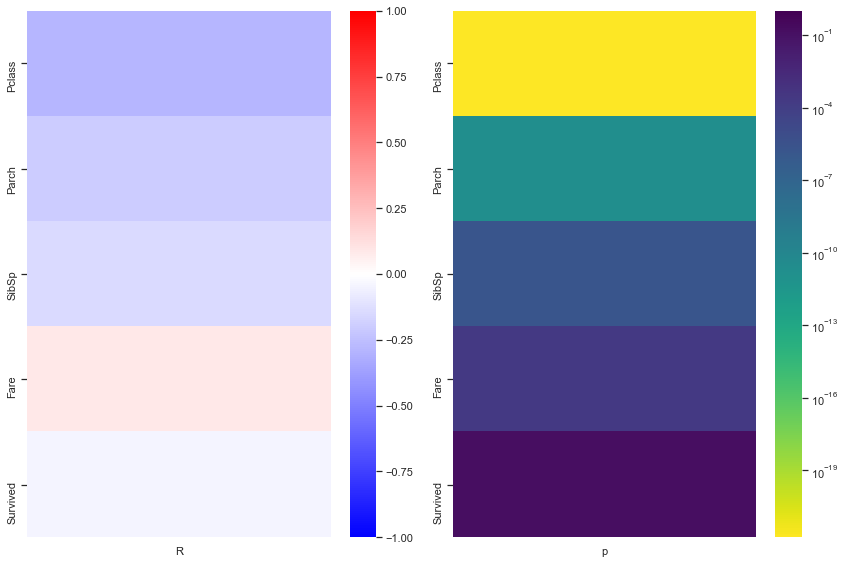

In [200]:
plotTargetCorrelation(allCorrelations, 'Age')

In [201]:
reference = 'Age'
validFeatures = X.select_dtypes(exclude=['float', 'int']).columns
for feature in validFeatures:
    if feature == reference:
        continue
    grouping = [group[reference].dropna().values for _, group in X.groupby(feature)]
    H, p = stats.kruskal(*grouping)
    if not np.isnan(H):
        print(feature, H, p)

Survived 1.970097978146391 0.16043746252207006
Sex 4.951032159109385 0.02607509661801354
Embarked 1.2484133404393043 0.5356862358343728


 https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc
        https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c

In [727]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [204]:
set_config(display='diagram')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

In [205]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to impute values by group """
    
    def __init__(self, variable, by, strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1)
        else:
            self.strategy = strategy

    def fit(self, X, y=None):
        self.map = X.groupby(self.by)[self.variable].agg(self.strategy)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        fillValues = X[self.by].apply(tuple, axis=1).map(self.map)
        X[self.variable] = X[self.variable].fillna(fillValues)
        return X

In [216]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """ Engineer custom features """

    def fit(self, X, y=None):
        return self

    
    def transform(self, X, y=None):
        X = X.copy()
        X['Relatives'] = X['SibSp'] + X['Parch']
        X['Title'] = X['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())
        X['Title'] = X['Title'].map(self._titles())
        return X
    
    
    def _titles(self):
        return {
            "Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"}

In [217]:
class NoTransformer(BaseEstimator, TransformerMixin):
    """ Dummy transformer """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

In [585]:
CountTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
CatTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot' , OneHotEncoder(handle_unknown='ignore')),
])
FareTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  RobustScaler()),
    ('power',   PowerTransformer(method='yeo-johnson'))
])

In [704]:
transformers = ([
    ('Count',  CountTransformer,  ['Pclass', 'Relatives']),
    ('Cat',    CatTransformer,    ['Sex', 'Embarked']),
    ('Fare',   FareTransformer,   ['Fare']),
    ('None',   NoTransformer(),   ['Age']),
])
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [728]:
# Define a preModel pipeline distinct from modelling step
preModel = Pipeline(steps=[
    ('engineer', FeatureEngineer()),
    ('ageImputer',      GroupImputer('Age', by=['Title', 'Sex'], strategy='median')),
    ('columnTransform', preprocessor),
])
# Create total workflow pipeline
pipeline = Pipeline(steps=[
    ('preModel', preModel),
    ('model',    GradientBoostingClassifier(random_state=0))
])

In [729]:
X = pd.read_csv(train, index_col=index, dtype=dtypes)
y = X.pop(target)

split = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
X_train, X_valid, y_train, y_valid = map(lambda x: x.copy(), split)

In [730]:
# Configure the cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
nJobs = -1
params =(
    {'model__C': Real(1e-6, 100, prior='log-uniform')}
)

params =(
    {'model__learning_rate': Real(1e-6, 1, prior='log-uniform')}
)

In [731]:
gridSearch = BayesSearchCV(
    pipeline, params, scoring='accuracy',
    cv=cv, refit=True, n_jobs=nJobs, n_iter=50)
gridSearch.fit(X_train, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=Pipeline(steps=[('preModel',
                                         Pipeline(steps=[('engineer',
                                                          FeatureEngineer()),
                                                         ('ageImputer',
                                                          GroupImputer(by=['Title',
                                                                           'Sex'],
                                                                       variable='Age')),
                                                         ('columnTransform',
                                                          ColumnTransformer(transformers=[('Count',
                                                                                           Pipeline(steps=[('imputer',
                                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                                           ['Pclass'...
                                                                                           Pipeline(steps=[('imputer',
                                                                                                            SimpleImputer(strategy='median')),
                                                                                                           ('scaler',
                                                                                                            RobustScaler()),
                                                                                                           ('power',
                                                                                                            PowerTransformer())]),
                                                                                           ['Fare']),
                                                                                          ('None',
                                                                                           NoTransformer(),
                                                                                           ['Age'])]))])),
                                        ('model',
                                         GradientBoostingClassifier(random_state=0))]),
              n_jobs=-1, scoring='accuracy',
              search_spaces={'model__learning_rate': Real(low=1e-06, high=1, prior='log-uniform', transform='identity')})

In [732]:
gridSearch.score(X_valid, y_valid)

0.8435754189944135

### Generate predictions
 - Refit model with full test dataset

In [733]:
gridSearch.fit(X, y)
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
predictions = gridSearch.predict(X_test).astype(int)
submission = pd.DataFrame({'PassengerId':X_test.index,'Survived': predictions})
submission.to_csv('submission.csv', index=False)

# Interpretation - assessing feature importance

In [735]:
def getFeatureNames(columnTransformer):
    """ Extract feature names from column transformer. 
        If transformers are pipelines then encoding step
        should be last
        Ref: https://github.com/scikit-learn/scikit-learn/issues/12525 
    """
    colNames = []
    for tupleTransformer in columnTransformer.transformers_[:-1]:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:
            names = tupleTransformer[2]
        if isinstance(names, str):
            colNames.append(names)
        else:
            colNames.extend(list(names))   
    return colNames

In [736]:
preModelTransformer = gridSearch.best_estimator_.named_steps['preModel']
columnTransformer = preModelTransformer.named_steps['columnTransform']
model = gridSearch.best_estimator_.named_steps['model']
featureNames = getFeatureNames(columnTransformer)

### Try out the preModelTransformer

In [737]:
transformedDf = pd.DataFrame(preModelTransformer.transform(X_valid), columns=featureNames)
transformedDf.head()

Pclass  Relatives  x0_female  x0_male  x1_C  x1_Q  x1_S      Fare   Age
0     3.0        0.0        0.0      1.0   1.0   0.0   0.0 -0.183216  30.0
1     3.0        0.0        0.0      1.0   0.0   0.0   1.0 -0.992692  30.0
2     3.0        5.0        0.0      1.0   0.0   1.0   0.0  0.661038   7.0
3     1.0        1.0        1.0      0.0   1.0   0.0   0.0  1.822165  35.0
4     3.0        2.0        1.0      0.0   1.0   0.0   0.0 -0.114130  29.0

In [738]:
eli5.explain_weights(model, feature_names=featureNames)

Explanation(estimator='GradientBoostingClassifier(learning_rate=0.14353044602922824, random_state=0)', description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='x0_male', weight=0.25155044373226726, std=0.13193800970580183, value=None), FeatureWeight(feature='Fare', weight=0.19379721513779571, std=0.281117921715559, value=None), FeatureWeight(feature='x0_female', weight=0.18814204283680855, std=0.13800352858709516, value=None), FeatureWeight(feature='Pclass', weight=0.13477851631164486, std=0.12372408963119981, value=None), FeatureWeight(feature='Age', weight=0.1278821793214798, std=0.23003147956175704, value=None), FeatureWeight(feature='Relatives', weight=0.0833435274196631, std=0.10617994429551207, value=None), FeatureWeight(feature='x1_S', weight=0.014468526371334431, std=0.04774877612109835, value=None), FeatureWeight(feature='x1_Q', weight=0.0034571609630528995, std=0.04371274884707653, value=None), FeatureWeight(feature='x1_C', weight=0.0025803879059533106, std=0.06635939862983273, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)